In [36]:
%matplotlib inline
import sys

In [37]:
sys.path.append("/kvh4/optic_disc/scripts") 
from dataset import ArrayDataset

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random

from PIL import Image

from monai.data import Dataset, list_data_collate, PNGSaver # , decollate_batch
# from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.transforms import (
    LoadImage,
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate,
    RandSpatialCrop,
    ScaleIntensity,
    AsChannelFirst,
    AsChannelLast, 
    RandFlip,
    ToTensor,
    Resize,
    # EnsureType,
)
from monai.visualize import plot_2d_or_3d_image
# from monai.data import ArrayDataset, create_test_image_2d # , decollate_batch
from torchvision.transforms import Lambda

from monai.utils import set_determinism
from monai.utils.misc import first
import torch

from typing import Optional, Callable

In [39]:
from monai.metrics import DiceMetric

In [40]:
def seed_everything(seed=1234):
    # source: https://github.com/pytorch/pytorch/issues/11278
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [41]:
# define all parameters:
nr_train_samples = 600
nr_val_samples = 100

In [42]:
image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/images"
images = os.listdir(image_dir)
images.remove(".ipynb_checkpoints")
image_paths = [os.path.join(image_dir, i) for i in images]

gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_paths = [os.path.join(gt_dir, i[:-4]+".bmp") for i in images]

In [43]:
training_images = image_paths[:nr_train_samples]
training_gt = gt_paths[:nr_train_samples]

validation_images = image_paths[nr_train_samples:(nr_train_samples+nr_val_samples)]
validation_gt = gt_paths[nr_train_samples:(nr_train_samples+nr_val_samples)]

In [95]:
glaucoma_image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/images"
glaucoma_images = [os.path.join(glaucoma_image_dir, g) for g in os.listdir(glaucoma_image_dir)]
glaucoma_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"
glaucoma_gt = [os.path.join(glaucoma_gt_dir, g) for g in os.listdir(glaucoma_gt_dir)]

In [96]:
gt_dir_ng ="/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_dir_g = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"

### Test the dataloader

In [44]:
test_images = image_paths[:10]
test_gt = gt_paths[:10]

In [45]:
# define training transformations (separately for input and gt)
test_imtransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         RandFlip(spatial_axis=1, prob=.5),
         RandFlip(spatial_axis=0, prob=.5),
         RandRotate(range_x=15, prob=0.3, keep_size=True),
         ScaleIntensity(),
         ToTensor()
        ]
    )

test_gttransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         RandFlip(spatial_axis=1, prob=.5),
         RandFlip(spatial_axis=0, prob=.5),
         RandRotate(range_x=15, prob=0.3, keep_size=True),
         ToTensor(),
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
         Lambda(lambda x: x[0,:,:]!=1),
         AddChannel()
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
        ]
    )

In [46]:
test_ds = ArrayDataset(test_images, test_imtransforms, test_gt, test_gttransforms)
# test_ds = RetinaDataset(test_images, test_imtransforms, test_gt, test_gttransforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=6) #, shuffle=True)

In [47]:
check_data = first(test_loader)

In [48]:
np.unique(check_data[0][1][0].numpy())

array([False,  True])

In [49]:
check_data[0][1][0].numpy().shape

(1, 512, 512)

In [50]:
check_data[1]

('T0088', 'V0099', 'V0151', 'V0200', 'T0097', 'T0332')

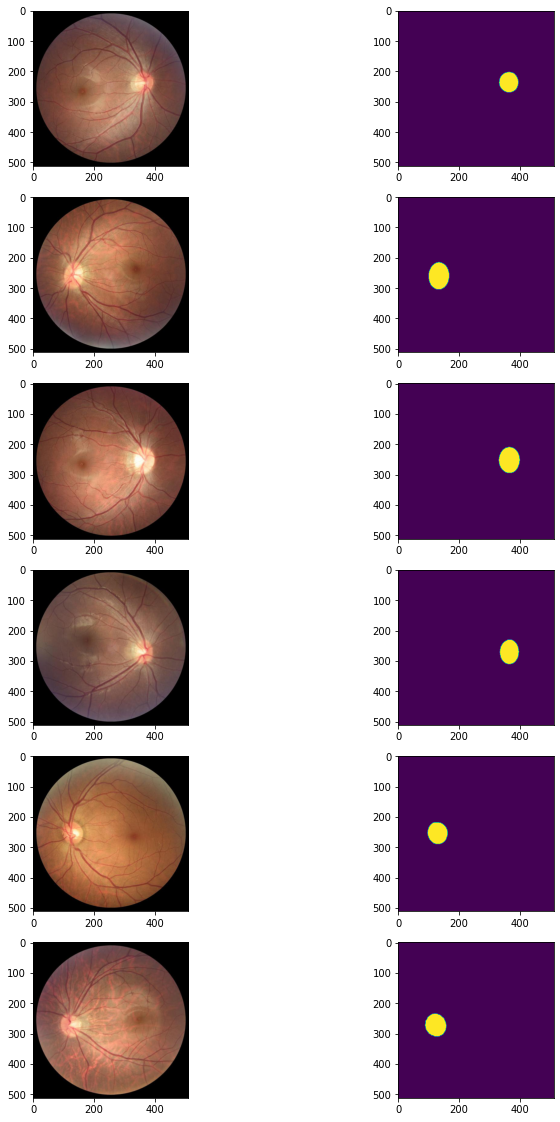

In [51]:
plt.subplots(6,2, figsize=(12,20))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    image = np.zeros((check_data[0][0][i][0].shape[0], check_data[0][0][i][0].shape[1],3))
    for c in range(3):
        image[:,:,c] = check_data[0][0][i][c]
    plt.imshow(image)
    plt.subplot(6,2,i*2+2)
    plt.imshow(check_data[0][1][i][0])

## Training and validation datasets

In [52]:
# define training transformations (separately for input and gt)
training_imtransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         RandFlip(spatial_axis=1, prob=.5),
         RandFlip(spatial_axis=0, prob=.5),
         RandRotate(range_x=15, prob=0.3, keep_size=True),
         ScaleIntensity(),
         ToTensor()
        ]
    )

training_gttransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         RandFlip(spatial_axis=1, prob=.5),
         RandFlip(spatial_axis=0, prob=.5),
         RandRotate(range_x=15, prob=0.3, keep_size=True),
         ToTensor(),
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
         Lambda(lambda x: x[0,:,:]!=1),
         AddChannel()
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
        ]
    )


validation_imtransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         ScaleIntensity(),
         ToTensor()
        ]
    )

validation_gttransforms = Compose(
        [ LoadImage(image_only=True),
         AsChannelFirst(),
         ToTensor(),
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
         Lambda(lambda x: x[0,:,:]!=1),
         AddChannel()
         # Lambda(lambda x: torch.cat([x==255, x==0,x==128], 0))
        ]
    )

In [53]:
training_ds = ArrayDataset(training_images, training_imtransforms, training_gt, training_gttransforms)
training_loader = torch.utils.data.DataLoader(training_ds, batch_size=12, shuffle=True)

validation_ds = ArrayDataset(validation_images, validation_imtransforms, validation_gt, validation_gttransforms)
validation_loader = torch.utils.data.DataLoader(validation_ds, batch_size=1, shuffle=False)

In [111]:
len(training_images)

600

In [112]:
len(validation_gt)

100

## Set up training

In [16]:
device = torch.device("cuda:3")

In [17]:
seed_everything(seed=0)

In [31]:
epoch_num = 100

model_dir = "/kvh4/optic_disc/models/07_UNet_wcc_cup_pw_5"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [19]:
# model
model = UNet(
        dimensions=2,
        in_channels=3,
        out_channels=1,
        channels=(8,16, 32, 64, 128),
        strides=(2, 2, 2, 2,2),
        # num_res_units=2,
        norm="batch",
        dropout = 0.0
    ).to(device)

In [20]:
# weights = [1, 10]                                                           
# weights = torch.Tensor(weights).cuda(device)
pos_weight = [20]                                                           
pos_weight = torch.Tensor(pos_weight).cuda(device)

In [21]:
dice_metric = DiceMetric(include_background=False, reduction="mean") #, get_not_nans=False)

# transforms for the output
post_trans_1 = Compose([ AddChannel(), Activations(sigmoid=True)])
post_trans_2 = Compose([ Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

# loss_function = DiceLoss(sigmoid=True)
# loss_function = torch.nn.CrossEntropyLoss(weight=weights)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight) # https://discuss.pytorch.org/t/should-i-use-nn-bcewithlogitsloss-or-cross-entropy-loss-for-segmentation/79476
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
val_interval = 1
# best_metric = -1
# best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
val_loss_values = list()
for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in training_loader:
        step += 1
        inputs, labels = batch_data[0][0].to(device), batch_data[0][1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(training_ds) // training_loader.batch_size
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        # writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    
    savepath = os.path.join(model_dir, "epoch_"+str(epoch+1)+".pth")
    print("savepath: ", savepath)
    torch.save(model.state_dict(), savepath)
    print("saved model")
    
   
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            metric_sum = 0.0
            metric_count = 0
            epoch_val_loss = list()
            for val_data in validation_loader:
                val_images, val_labels = val_data[0][0].to(device), val_data[0][1].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                epoch_val_loss.append(loss_function(val_outputs, val_labels.float()).item())
                # val_outputs = [post_trans_1(i) for i in val_outputs]
                val_outputs = post_trans_1(val_outputs[0])
                # compute metric for current iteration
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                metric_count += len(value)
                metric_sum += value.item() * len(value)
            metric = metric_sum / metric_count
            metric_values.append(metric)
            val_loss_values.append(np.mean(epoch_val_loss))
            # reset the status for next validation round
            # dice_metric.reset()
        
            
            print(
                "current epoch: {} current mean dice: {:.4f}".format(
                    epoch + 1, metric
                )
            )
            print("val loss: ",np.mean(epoch_val_loss))
            
np.save(os.path.join(model_dir, "epoch_loss.npy"), epoch_loss_values)
np.save(os.path.join(model_dir, "val_metrics.npy"), metric_values)
np.save(os.path.join(model_dir, "val_loss.npy"), val_loss_values)

----------
epoch 1/100
epoch 1 average loss: 0.9020
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0722
val loss:  0.7988558351993561
----------
epoch 2/100
epoch 2 average loss: 0.7758
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0872
val loss:  0.751608698964119
----------
epoch 3/100
epoch 3 average loss: 0.6983
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.0993
val loss:  0.7022732239961624
----------
epoch 4/100
epoch 4 average loss: 0.6433
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1210
val loss:  0.6542618179321289
----------
epoch 5/100
epoch 5 average loss: 0.6001
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.1604
val loss:  0.616295634508133
----------
epoch 6/100
epoch 6 average loss: 0.5653
savepath:  /kvh4/optic_disc/models/08_UNet_wcc_cup_pw

In [76]:

model_dir = "/kvh4/optic_disc/models/07_UNet_wcc_cup_pw_5"

In [77]:
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_dice = np.load(os.path.join(model_dir, "val_metrics.npy"))

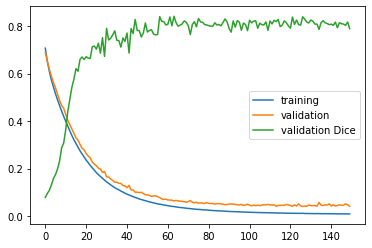

In [78]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_dice, label="validation Dice")
plt.plot
plt.legend()

In [79]:
np.argmax(val_dice)

63

## Inference
 - on both the validation and the test data ... save to different folders
 - save outputs as .npy files (easier to load them back in ... no dataformat parsing required)
 - overwrite the validation dataset!!!!!

In [61]:
save_dir = os.path.join(model_dir, "test_preds_epoch_")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [62]:
test_images = image_paths[(nr_train_samples+nr_val_samples):]
test_gt = gt_paths[(nr_train_samples+nr_val_samples):]

In [65]:
validation_ds = ArrayDataset(test_images, validation_imtransforms, test_gt, validation_gttransforms)
validation_loader = torch.utils.data.DataLoader(validation_ds, batch_size=1, shuffle=False)

In [63]:
len(test_images)

381

In [66]:
model.load_state_dict(torch.load(os.path.join(model_dir,"epoch_94.pth")))
model.eval()
with torch.no_grad():
    saver = PNGSaver(output_dir=save_dir)
    for val_data in validation_loader:
        val_images, val_labels = val_data[0][0].to(device), val_data[0][1].to(device)
        # define sliding window size and batch size for windows inference
        roi_size = (96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        val_outputs = post_trans_1(val_outputs[0])
        # compute metric for current iteration

        # val_pred_list.append(val_outputs)
        # val_label_list.append(val_labels)
        # val_input_list.append(val_images)
        print(val_data[1][0])
        output_np = val_outputs.cpu().detach().numpy()[0,0,:,:]
        np.save(os.path.join(save_dir,val_data[1][0]+".npy"),output_np)

V0382
n0180
T0079
T0217
n0185
n0175
T0290
V0326
V0317
V0245
n0271
V0304
n0006
T0056
V0250
T0009
n0191
n0343
V0388
n0049
V0071
V0180
T0104
V0394
V0310
V0043
n0176
n0263
V0140
n0103
V0052
V0290
n0027
T0001
V0357
T0061
V0256
V0143
n0145
V0360
T0035
V0058
V0122
T0027
V0395
V0117
T0026
T0090
V0362
T0129
n0359
T0327
T0074
T0246
V0091
T0092
V0346
T0192
T0125
n0293
n0064
T0111
n0173
n0237
V0235
n0305
n0320
V0134
V0036
n0021
n0290
T0289
V0152
n0123
T0374
n0321
V0253
n0222
n0269
T0078
T0257
n0143
T0115
n0298
T0093
T0083
T0351
n0011
V0097
T0333
n0044
V0067
T0391
T0086
n0007
V0361
V0365
V0359
V0191
V0203
n0082
T0137
T0256
n0135
n0070
n0079
V0306
T0278
T0143
V0147
V0021
n0114
n0262
n0019
V0230
T0307
n0088
n0273
V0325
n0270
T0211
T0158
n0326
T0341
T0042
T0228
T0105
n0108
V0348
T0034
V0343
T0004
n0336
T0357
n0038
T0103
V0093
T0029
V0269
V0303
V0129
T0321
V0027
T0381
T0112
n0338
T0036
n0207
n0066
n0109
n0018
V0096
V0288
V0178
V0173
n0156
V0284
T0066
T0297
T0335
V0116
V0079
n0188
n0140
n0008
V0126
n034

FileNotFoundError: Applying transform <monai.transforms.compose.Compose object at 0x7fe480c54cc0>.

## Evaluation

In [74]:
def load_gt(data_dir, case_name, mode=None):

    gt = np.asarray(Image.open(os.path.join(data_dir, case_name+".bmp"))).astype(int)
    
    if mode == "cup":
        cup = np.zeros(gt.shape[:2])
        cup[np.where(gt[:,:,0] == 0)] = 1
        return cup
        
    elif mode == "disc":
        print("disc")
        disc = gt[:,:,1]
        return disc
    
    else:
        print("full gt")
        return gt

In [75]:
def load_pred(data_dir, case_name):
    
    return np.load(os.path.join(data_dir, case_name+".npy"))

In [ ]:
gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
case_name = "n0020"

save_dir = "/kvh4/optic_disc/models/03_UNet_cup/test_preds_epoch_60"

In [ ]:
pred = load_pred(save_dir, case_name)

In [ ]:
plt.imshow(pred)

In [ ]:
gt = load_gt(gt_dir, case_name,mode="cup")

In [ ]:
plt.imshow(gt)

In [79]:
def binarize_pred(pred, binarization_threshold=.5):
    
    binarized = np.zeros(pred.shape)
    binarized[np.where(pred >= binarization_threshold)] = 1
    
    return binarized

In [ ]:
bin = binarize_pred(pred)

In [ ]:
plt.imshow(bin)

In [ ]:
np.unique(bin)

In [77]:
def calc_dice(gt, pred, binarize=False):
    
    if binarize:
        pred = binarize_pred(pred)
        
    right_positives = np.round(np.multiply(pred,gt)).astype(int)
    dice = (2.0*np.sum(right_positives)+1)/(np.sum(pred)+np.sum(gt)+1)
    
    return dice

In [ ]:
calc_dice(gt, bin)

In [82]:
def generate_max_softmax_uncertainty(pseudoprob_pred):

    return abs(pseudoprob_pred - 0.5)*(-2)+1 #absolute distance from .5 (and scale)

In [ ]:
max_softmax = generate_max_softmax_uncertainty(pred)

In [ ]:
plt.imshow(max_softmax)

In [81]:
def calc_mean_voxelwise_uncertainty(voxelwise_uncertainty, pred, binarize=False, binarization_threshold=.5):
    # input: voxelwise uncertainty map and prediction (binarized or mean pseudoprob)
    # output: mean uncertainty over the labelled region

    if binarize:
        pred = binarize_pred(pred, binarization_threshold=binarization_threshold)
    else:
        pred = pred.astype(int) # just to make sure that the prediction is an integer array
    
    return np.mean(voxelwise_uncertainty[np.nonzero(pred)]) # calculate voxelwise uncertainty for all voxels labelled as foreground (mask and calc mean over non-zero values)

In [ ]:
calc_mean_voxelwise_uncertainty(max_softmax, bin)

In [90]:
def compute_dice_dataset(names, gt_dir, pred_dir, mode=None): 

    # does not support multi-label eval yet
    dice_dict = dict()

    for n in names:
        
        gt = load_gt(gt_dir, n, mode=mode) # load gt
        pred = load_pred(pred_dir, n) # load pred

        dice = calc_dice(gt, pred, binarize=True)# compute_dice

        dice_dict[n] = dice
        
    return dice_dict

In [84]:
test_names = [n[-9:-4] for n in test_images]
val_names = [n[-9:-4] for n in validation_images]

In [85]:
gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
save_dir = '/kvh4/optic_disc/models/06_UNet_wcc_cup/val_preds_epoch_94'

0.8218379042161277
0.9265411263101794
0.7841035120147875
0.9233623336745138
0.854868720281166
0.9026949987043276


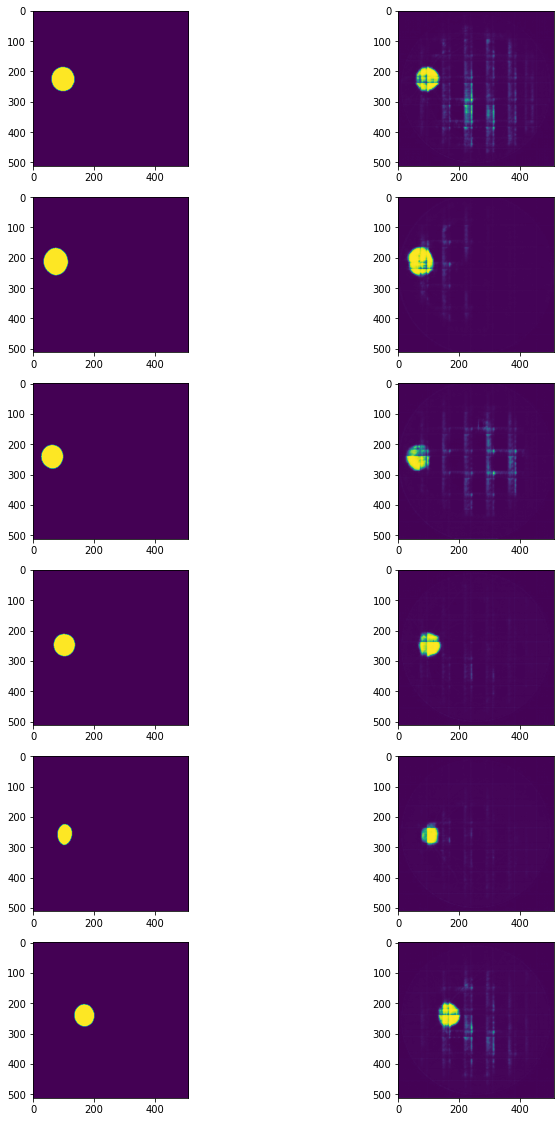

In [86]:
plt.subplots(6,2, figsize=(12,20))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    gt = load_gt(gt_dir, val_names[i], mode="cup")
    plt.imshow(gt)
    plt.subplot(6,2,i*2+2)
    pred = load_pred(save_dir, val_names[i])
    plt.imshow(pred)
    print(calc_dice(gt, pred, binarize=True))

In [91]:
wcc_val_res = compute_dice_dataset(val_names, gt_dir, save_dir, mode="cup")

In [96]:
np.mean(list(wcc_val_res.values()))

0.8550766542386199

In [89]:
val_names

['V0308',
 'n0095',
 'n0310',
 'T0238',
 'V0390',
 'V0069',
 'T0400',
 'V0034',
 'T0293',
 'n0205',
 'T0245',
 'T0300',
 'T0102',
 'T0251',
 'V0088',
 'T0354',
 'T0140',
 'V0299',
 'n0334',
 'V0157',
 'T0202',
 'T0057',
 'T0060',
 'T0292',
 'T0279',
 'n0077',
 'T0025',
 'T0058',
 'V0324',
 'V0022',
 'V0267',
 'n0057',
 'n0268',
 'T0224',
 'n0139',
 'n0092',
 'V0039',
 'V0087',
 'n0352',
 'T0169',
 'n0182',
 'n0303',
 'n0306',
 'n0072',
 'n0332',
 'n0302',
 'T0142',
 'n0354',
 'V0282',
 'V0070',
 'V0351',
 'n0214',
 'n0093',
 'T0305',
 'T0018',
 'n0059',
 'T0032',
 'T0068',
 'T0273',
 'V0145',
 'n0292',
 'n0071',
 'V0172',
 'V0277',
 'T0195',
 'n0225',
 'n0223',
 'V0328',
 'V0177',
 'T0274',
 'T0338',
 'T0316',
 'n0323',
 'T0323',
 'V0109',
 'T0073',
 'V0355',
 'n0316',
 'T0045',
 'T0298',
 'T0373',
 'T0248',
 'V0386',
 'n0128',
 'V0234',
 'n0335',
 'V0215',
 'n0009',
 'V0163',
 'n0350',
 'T0156',
 'n0165',
 'T0362',
 'n0295',
 'n0107',
 'n0249',
 'V0321',
 'T0260',
 'T0359',
 'V0289']

In [87]:
sys.path.append("/kvh4/optic_disc/scripts") 
from training import train_dice, train_bce, train_dice_MC, run_inference, run_MC_inference
from evaluation_functions import compute_dice_dataset, \
                                    compute_max_softmax_uncertainty_dataset, load_pred, compute_mean_uncertainty_dataset

In [102]:
def eval_mean_uncertainty(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g, sampling=False):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=sampling)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_uncertainty_dataset(train_names, pred_dir_training, sampling=sampling)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=sampling)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_uncertainty_dataset(test_names, pred_dir_test, sampling=sampling)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=sampling)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_uncertainty_dataset(g_names, pred_dir_g, sampling=sampling)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean uncertainty")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

In [82]:
filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [89]:
model_dir = "/kvh4/optic_disc/models/07_UNet_wcc_cup_pw_5"

filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [97]:
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

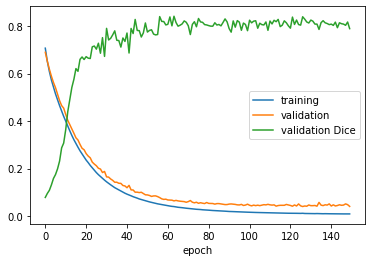

In [98]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [90]:
inference_parameters_test_5 = {"model_dir": model_dir, 
                         "model_epoch": 63,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(model_dir, "test_pred_epoch_63")}

In [91]:
run_inference(**inference_parameters_test_5)

finished inference


In [92]:
inference_parameters_train_5 = {"model_dir": model_dir, 
                         "model_epoch": 63,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(model_dir, "training_pred_epoch_63")}

In [93]:
run_inference(**inference_parameters_train_5)

finished inference


In [99]:
inference_parameters_glaucoma_5 = {"model_dir": model_dir, 
                         "model_epoch": 63,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(model_dir, "glaucoma_pred_epoch_63")}

In [100]:
run_inference(**inference_parameters_glaucoma_5)

finished inference


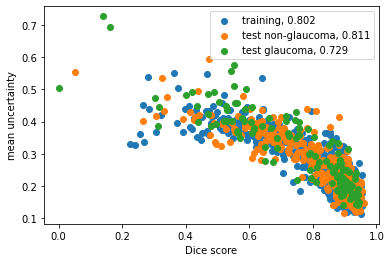

In [103]:
model_dir = model_dir
eval_dict_5 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_63"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_63"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_63"), 
             "sampling": False}

bce_seed_5_eval = eval_mean_uncertainty(**eval_dict_5)

In [104]:
model_dir = "/kvh4/optic_disc/models/08_UNet_wcc_cup_pw_20"

In [105]:
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

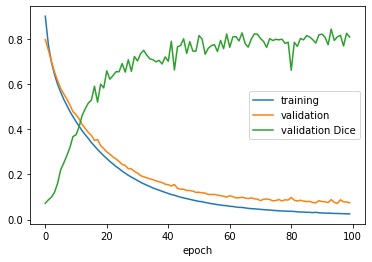

In [106]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [108]:
np.argmax(val_metrics)

93

In [109]:
inference_parameters_test_20 = {"model_dir": model_dir, 
                         "model_epoch": 93,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(model_dir, "test_pred_epoch_93")}

In [110]:
run_inference(**inference_parameters_test_20)

finished inference


In [111]:
inference_parameters_train_20 = {"model_dir": model_dir, 
                         "model_epoch": 93,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(model_dir, "training_pred_epoch_93")}

In [113]:
run_inference(**inference_parameters_train_20)

finished inference


In [112]:
inference_parameters_glaucoma_20 = {"model_dir": model_dir, 
                         "model_epoch": 93,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(model_dir, "glaucoma_pred_epoch_93")}

In [114]:
run_inference(**inference_parameters_glaucoma_20)

finished inference


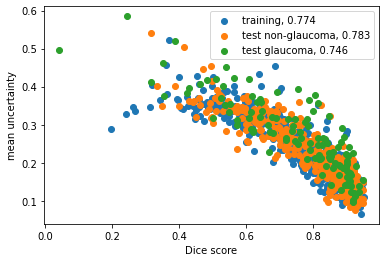

In [115]:
model_dir = model_dir
eval_dict_20 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_93"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_93"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_93"), 
             "sampling": False}

bce_seed_20_eval = eval_mean_uncertainty(**eval_dict_20)

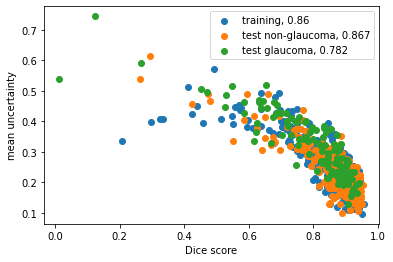

In [116]:
model_dir = "/kvh4/optic_disc/models/06_UNet_wcc_cup_pw_10"
eval_dict_10 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_94"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_94"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_94"), 
             "sampling": False}

bce_seed_10_eval = eval_mean_uncertainty(**eval_dict_10)